<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [1]:
import time
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_absolute_percentage_error,
                             mean_squared_error,
                             mean_absolute_error)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

!pip install catboost
!pip install xgboost
!pip install lightgbm

import xgboost as xgb
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


In [2]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [4]:
df.head(3)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S


In [5]:
for column in df.select_dtypes(include=['object']):
    print(f'Column: {column}. \nUnique values: {df[column].unique()}')
    print()

Column: experience_level. 
Unique values: ['SE' 'MI' 'EN' 'EX']

Column: employment_type. 
Unique values: ['FT' 'CT' 'FL' 'PT']

Column: job_title. 
Unique values: ['Principal Data Scientist' 'ML Engineer' 'Data Scientist'
 'Applied Scientist' 'Data Analyst' 'Data Modeler' 'Research Engineer'
 'Analytics Engineer' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Strategist' 'Data Engineer'
 'Computer Vision Engineer' 'Data Quality Analyst'
 'Compliance Data Analyst' 'Data Architect'
 'Applied Machine Learning Engineer' 'AI Developer' 'Research Scientist'
 'Data Analytics Manager' 'Business Data Analyst' 'Applied Data Scientist'
 'Staff Data Analyst' 'ETL Engineer' 'Data DevOps Engineer' 'Head of Data'
 'Data Science Manager' 'Data Manager' 'Machine Learning Researcher'
 'Big Data Engineer' 'Data Specialist' 'Lead Data Analyst'
 'BI Data Engineer' 'Director of Data Science'
 'Machine Learning Scientist' 'MLOps Engineer' 'AI Scientist'
 'Autonomous Vehicle Technician' 

## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [6]:
print(f"Кол-во ропущенных значений: {df.isnull().sum().sum()}")
print(f"\nКоличество дубликатов: {df.duplicated().sum()}")

Кол-во ропущенных значений: 0

Количество дубликатов: 1171


In [7]:
df.drop_duplicates(keep='first', inplace=True)

In [8]:
df.reset_index(drop=True, inplace=True)
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
2579,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
2580,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
2581,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
2582,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная

**Ваша задача:** построение модели бустинга и оценка данной модели.

В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты

In [9]:
for column in df.select_dtypes(include=['object']):
    if df[column].nunique() > 10:
        print(f'В признаке {column} много категорий! ({df[column].nunique()})')

В признаке job_title много категорий! (93)
В признаке salary_currency много категорий! (20)
В признаке employee_residence много категорий! (78)
В признаке company_location много категорий! (72)


Признаки salary и salary_currency можно удалить, т.к. target (salary_in_usd) уже содержит нормализованную в долларах информацию о зарплате

In [10]:
df = df.drop(['salary', 'salary_currency'], axis=1)

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [11]:
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [12]:
df.head(3)

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,US,100,US,S


In [13]:
continuous_features = ['work_year', 'remote_ratio']
categorical_features = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']

X_continuous = df[continuous_features]

X_train_continuous, X_test_continuous, y_train, y_test = train_test_split(
    X_continuous, y, test_size=0.2, random_state=12345
)

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [14]:
lr = LinearRegression().fit(X_train_continuous, y_train)

y_pred = lr.predict(X_test_continuous)

mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAPE:", mape)
print("RMSE:", rmse)

MAPE: 0.8720152330827866
RMSE: 65284.230223894076


In [15]:
y.mean(), y.std(), y.median()

(133409.28018575851, 67136.83732925021, 130000.0)

Как мы можем видеть модель показала себя не очень хорошо. Средяя ошибка прогноза модели составляет 87%, также RMSE +- равен нашему STD

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [16]:
xgb_model = xgb.XGBRegressor().fit(X_train_continuous, y_train)

y_pred = xgb_model.predict(X_test_continuous)

mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAPE:", mape)
print("RMSE:", rmse)

MAPE: 0.820504903793335
RMSE: 63873.78153828064


Данных слишком мало, они недостаточно информативны, модель опять получилось достаточно скудной по обобщению. Ошибка прогноза снова 80%+

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

### OHE

In [17]:
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_data = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_features))

X_encoded = pd.concat([df[continuous_features].reset_index(drop=True), encoded_df], axis=1)
X_encoded

,work_year,remote_ratio,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,...,company_location_SI,company_location_SK,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_size_L,company_size_M,company_size_S
0,2023,100,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2023,100,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2023,100,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,2023,100,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2023,100,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2579,2020,100,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2580,2021,100,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2581,2020,100,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2582,2020,100,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [18]:
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=12345)

xgb_model = xgb.XGBRegressor().fit(X_train_encoded, y_train)
xgb_pred = xgb_model.predict(X_test_encoded)

lr_model = LinearRegression().fit(X_train_encoded, y_train)
lr_pred = lr_model.predict(X_test_encoded)

xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

lr_mape = mean_absolute_percentage_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

print("OHE:")
print("XGBoost - MAPE:", xgb_mape, "RMSE:", xgb_rmse)
print("Linear Regression - MAPE:", lr_mape, "RMSE:", lr_rmse)

OHE:
XGBoost - MAPE: 0.44017693400382996 RMSE: 50730.93636037088
Linear Regression - MAPE: 0.45476088601638387 RMSE: 52806.69076790306


Уже неплохой результат почти в 2 раза удалось снизить процень ошибки: 40%

### LE

In [24]:
label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_features}
encoded_le_df = df.copy()

for col, encoder in label_encoders.items():
    encoded_le_df[col] = encoder.transform(df[col])

print(encoded_le_df[categorical_features])

X_le = encoded_le_df[continuous_features + categorical_features]
X_train_le, X_test_le, y_train, y_test = train_test_split(X_le, y, test_size=0.2, random_state=12345)

xgb_model = xgb.XGBRegressor().fit(X_train_le, y_train)
xgb_pred = xgb_model.predict(X_test_le)

lr_model = LinearRegression().fit(X_train_le, y_train)
lr_pred = lr_model.predict(X_test_le)

xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
lr_mape = mean_absolute_percentage_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

print("Label Encoding:")
print("XGBoost - MAPE:", xgb_mape, "RMSE:", xgb_rmse)
print("Linear Regression - MAPE:", lr_mape, "RMSE:", lr_rmse)

      experience_level  employment_type  job_title  employee_residence  \
0                    3                2         84                  26   
1                    2                0         66                  75   
2                    2                0         66                  75   
3                    3                2         47                  11   
4                    3                2         47                  11   
...                ...              ...        ...                 ...   
2579                 3                2         47                  75   
2580                 2                2         84                  75   
2581                 0                2         47                  75   
2582                 0                0         17                  75   
2583                 3                2         45                  39   

      company_location  company_size  
0                   25             0  
1                   70           

### Target Ecoding

In [26]:
mean_encodings = {}
encoded_te_df = df.copy()

for col in categorical_features:
    mean_encodings[col] = df.groupby(col)['salary_in_usd'].mean()
    encoded_te_df[col] = df[col].map(mean_encodings[col])

X_te = encoded_te_df[continuous_features + categorical_features]
X_train_te, X_test_te, y_train, y_test = train_test_split(X_te, y, test_size=0.2, random_state=12345)

xgb_model = xgb.XGBRegressor().fit(X_train_te, y_train)
xgb_pred = xgb_model.predict(X_test_te)

lr_model = LinearRegression().fit(X_train_te, y_train)
lr_pred = lr_model.predict(X_test_te)

xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
lr_mape = mean_absolute_percentage_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

print("Mean Target Encoding:")
print("XGBoost - MAPE:", xgb_mape, "RMSE:", xgb_rmse)
print("Linear Regression - MAPE:", lr_mape, "RMSE:", lr_rmse)

encoded_te_df[categorical_features].head(5)

Mean Target Encoding:
XGBoost - MAPE: 0.4062250852584839 RMSE: 52013.99196370146
Linear Regression - MAPE: 0.4546833477190769 RMSE: 49992.20951637651


,experience_level,employment_type,job_title,employee_residence,company_location,company_size
0,153897.435650,134434.613271,198171.125000,62933.531915,58224.204545,113202.239609
1,101828.783133,113446.900000,158352.441176,153972.206550,152374.791602,78364.278912
2,101828.783133,113446.900000,158352.441176,153972.206550,152374.791602,78364.278912
3,153897.435650,134434.613271,132974.587361,130859.839506,130572.759036,141474.514300
4,153897.435650,134434.613271,132974.587361,130859.839506,130572.759036,141474.514300


Лучшей моделью и стратегией стали: XGBoost и Target Encoding: MAPE: 40.6% RMSE: 52013.

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [27]:
errors = np.abs(y_test - xgb_pred)

results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': xgb_pred,
    'Error': errors
}, index=y_test.index)

df.loc[results.sort_values(by='Error', ascending=False).head(20).index]

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1352,2022,MI,FT,Data Analyst,430967,GB,0,GB,M
2,2023,MI,CT,ML Engineer,25500,US,100,US,S
1684,2022,SE,FT,Data Architect,345600,US,0,US,M
1,2023,MI,CT,ML Engineer,30000,US,100,US,S
2348,2020,SE,FT,Data Scientist,68428,GR,100,US,L
1117,2023,SE,FT,Applied Scientist,72000,US,0,US,L
131,2023,SE,FT,Machine Learning Engineer,342300,US,0,US,L
794,2023,SE,FT,Machine Learning Engineer,323300,US,0,US,M
1372,2022,EN,FT,AI Scientist,200000,CA,50,CA,L
987,2023,SE,FT,Data Engineer,300000,US,0,US,M


**Ваш ответ здесь**.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

# Стаж

In [30]:
df['experience'] = 2023 - df['work_year']

In [31]:
mean_encodings = {}
encoded_te_df = df.copy()

for col in categorical_features:
    mean_encodings[col] = df.groupby(col)['salary_in_usd'].mean()
    encoded_te_df[col] = df[col].map(mean_encodings[col])

X_te = encoded_te_df[continuous_features + categorical_features]
X_train_te, X_test_te, y_train, y_test = train_test_split(X_te, y, test_size=0.2, random_state=12345)

xgb_model = xgb.XGBRegressor().fit(X_train_te, y_train)
xgb_pred = xgb_model.predict(X_test_te)

lr_model = LinearRegression().fit(X_train_te, y_train)
lr_pred = lr_model.predict(X_test_te)

xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
lr_mape = mean_absolute_percentage_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

print("Mean Target Encoding:")
print("XGBoost - MAPE:", xgb_mape, "RMSE:", xgb_rmse)
print("Linear Regression - MAPE:", lr_mape, "RMSE:", lr_rmse)

Mean Target Encoding:
XGBoost - MAPE: 0.4062250852584839 RMSE: 52013.99196370146
Linear Regression - MAPE: 0.4546833477190769 RMSE: 49992.20951637651


**Ваш ответ здесь**.

Сам по себе признак неплохой, но толку для модели сильно не дал

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [32]:
train_pool = Pool(X_train_te, y_train)
test_pool = Pool(X_test_te, y_test)

In [33]:
start_time = time.time()

model = CatBoostRegressor(verbose=0).fit(train_pool)

end_time = time.time()
training_time = end_time - start_time
print(f'Время обучения CB: {training_time} секунд')

Время обучения CB: 0.611940860748291 секунд


In [34]:
param_grid = {
    'depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(estimator=CatBoostRegressor(verbose=0),
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_absolute_error',
                           verbose=1)

start_time = time.time()

grid_search.fit(X_train_te, y_train)

end_time = time.time()
tuning_time = end_time - start_time
print(f'Время подбора гиперпараметров CB: {tuning_time} секунд')

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Время подбора гиперпараметров CB: 24.7130925655365 секунд


In [35]:
best_params = grid_search.best_params_
best_params

{'depth': 5, 'learning_rate': 0.01}

In [36]:
start_time = time.time()

best_model = CatBoostRegressor(**best_params, verbose=0).fit(train_pool)

end_time = time.time()
print(f'Время обучения улучшенной модели CB: {end_time - start_time} секунд')

Время обучения улучшенной модели CB: 0.49147701263427734 секунд


In [37]:
start_time = time.time()

predictions = best_model.predict(test_pool)

end_time = time.time()
print(f'Время предсказания CB: {end_time - start_time} секунд')

Время предсказания CB: 0.005463838577270508 секунд


In [38]:
cb_mape = mean_absolute_percentage_error(y_test, predictions)
cb_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("CatBoost - MAPE:", cb_mape, "RMSE:", cb_rmse)

CatBoost - MAPE: 0.4037296376014713 RMSE: 49064.56577012822


## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [39]:
start_time = time.time()

xgb_model = xgb.XGBRegressor().fit(X_train_te, y_train)

end_time = time.time()
print(f'Время обучения XGB: {end_time - start_time} секунд')

Время обучения XGB: 0.04783058166503906 секунд


In [40]:
param_grid = {
    'max_depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(),
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_absolute_error',
                           verbose=1)

start_time = time.time()

grid_search.fit(X_train_te, y_train)

end_time = time.time()
print(f'Время подбора гиперпараметров: {end_time - start_time} секунд')

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Время подбора гиперпараметров: 2.3862826824188232 секунд


In [41]:
best_params_xgb = grid_search.best_params_
best_params_xgb

{'learning_rate': 0.1, 'max_depth': 4}

In [42]:
start_time = time.time()

best_model_xgb = xgb.XGBRegressor(**best_params).fit(X_train_te, y_train)

end_time = time.time()
print(f'Время обучения улучшенной модели XGB: {end_time - start_time} секунд')

Время обучения улучшенной модели XGB: 0.0534815788269043 секунд


In [43]:
start_time = time.time()

predictions = best_model_xgb.predict(X_test_te)

end_time = time.time()
print(f'Время предсказания XGB: {end_time - start_time} секунд')

Время предсказания XGB: 0.006110191345214844 секунд


In [44]:
xgb_mape = mean_absolute_percentage_error(y_test, predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("XGB - MAPE:", xgb_mape, "RMSE:", xgb_rmse)

XGB - MAPE: 0.5735280513763428 RMSE: 51627.48291365753


## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [45]:
start_time = time.time()

lgb_model = lgb.LGBMRegressor(force_row_wise=True).fit(X_train_te, y_train)

end_time = time.time()
print(f'Время обучения LightGBM: {end_time - start_time} секунд')

[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 8
[LightGBM] [Info] Start training from score 133963.476052
Время обучения LightGBM: 0.09254169464111328 секунд


In [46]:
lgb_train = lgb.Dataset(X_train_te, label=y_train, params={'verbose': -1}, free_raw_data=False)

start_time = time.time()

model_base = lgb.train(params={'max_depth': 4},
                       train_set=lgb_train,
                       num_boost_round=100)

end_time = time.time()
print(f'Время обучения базовой модели LightGBM: {end_time - start_time} секунд')

Время обучения базовой модели LightGBM: 0.3124699592590332 секунд


In [47]:
grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(force_row_wise=True),
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_absolute_error',
                           verbose=1)

start_time = time.time()

grid_search.fit(X_train_te, y_train)

end_time = time.time()
print(f'Время подбора гиперпараметров LightGBM: {end_time - start_time} секунд')


Fitting 3 folds for each of 15 candidates, totalling 45 fits
Время подбора гиперпараметров LightGBM: 2.010953903198242 секунд


In [48]:
best_params_le = grid_search.best_params_
best_params_le

{'learning_rate': 0.1, 'max_depth': 4}

In [49]:
lgb_test = lgb.Dataset(X_test_te, label=y_test, params={'verbose': -1}, free_raw_data=False)

start_time = time.time()

best_model = lgb.train(params=best_params_le,
                       train_set=lgb_train,
                       num_boost_round=100)

end_time = time.time()
print(f'Время обучения улучшенной модели: {end_time - start_time} секунд')

Время обучения улучшенной модели: 0.01759171485900879 секунд


In [50]:
start_time = time.time()

predictions = best_model.predict(X_test_te)

end_time = time.time()
print(f'Время предсказания: {end_time - start_time} секунд')

Время предсказания: 0.0046465396881103516 секунд


In [51]:
lgbm_mape = mean_absolute_percentage_error(y_test, predictions)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("LGBM - MAPE:", lgbm_mape, "RMSE:", lgbm_rmse)

LGBM - MAPE: 0.3912893398041307 RMSE: 48980.667680137


## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

Лучше всех себя показала модель LightGBM и по скорости и по качеству! Бустинг достаточно сильно превзашёл обычную линейную модель. В данной задаче не целесообразно использовать Лин.Рег.

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [52]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
from time import time

# plt.style.use(['seaborn-darkgrid'])
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [54]:
X_train = pd.read_csv('samsung_train.txt', sep='\s+', header=None)
y_train = pd.read_csv('samsung_train_labels.txt', sep='\s+', header=None)
X_test = pd.read_csv('samsung_test.txt', sep='\s+', header=None)
y_test = pd.read_csv('samsung_test_labels.txt', sep='\s+', header=None)

X = np.vstack((X_train, X_test))
y = np.hstack((y_train.values.ravel(), y_test.values.ravel()))

In [55]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [57]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f"Суммарная дисперсия: {np.sum(pca.explained_variance_ratio_)}")

Суммарная дисперсия: 0.9004833346822928


### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

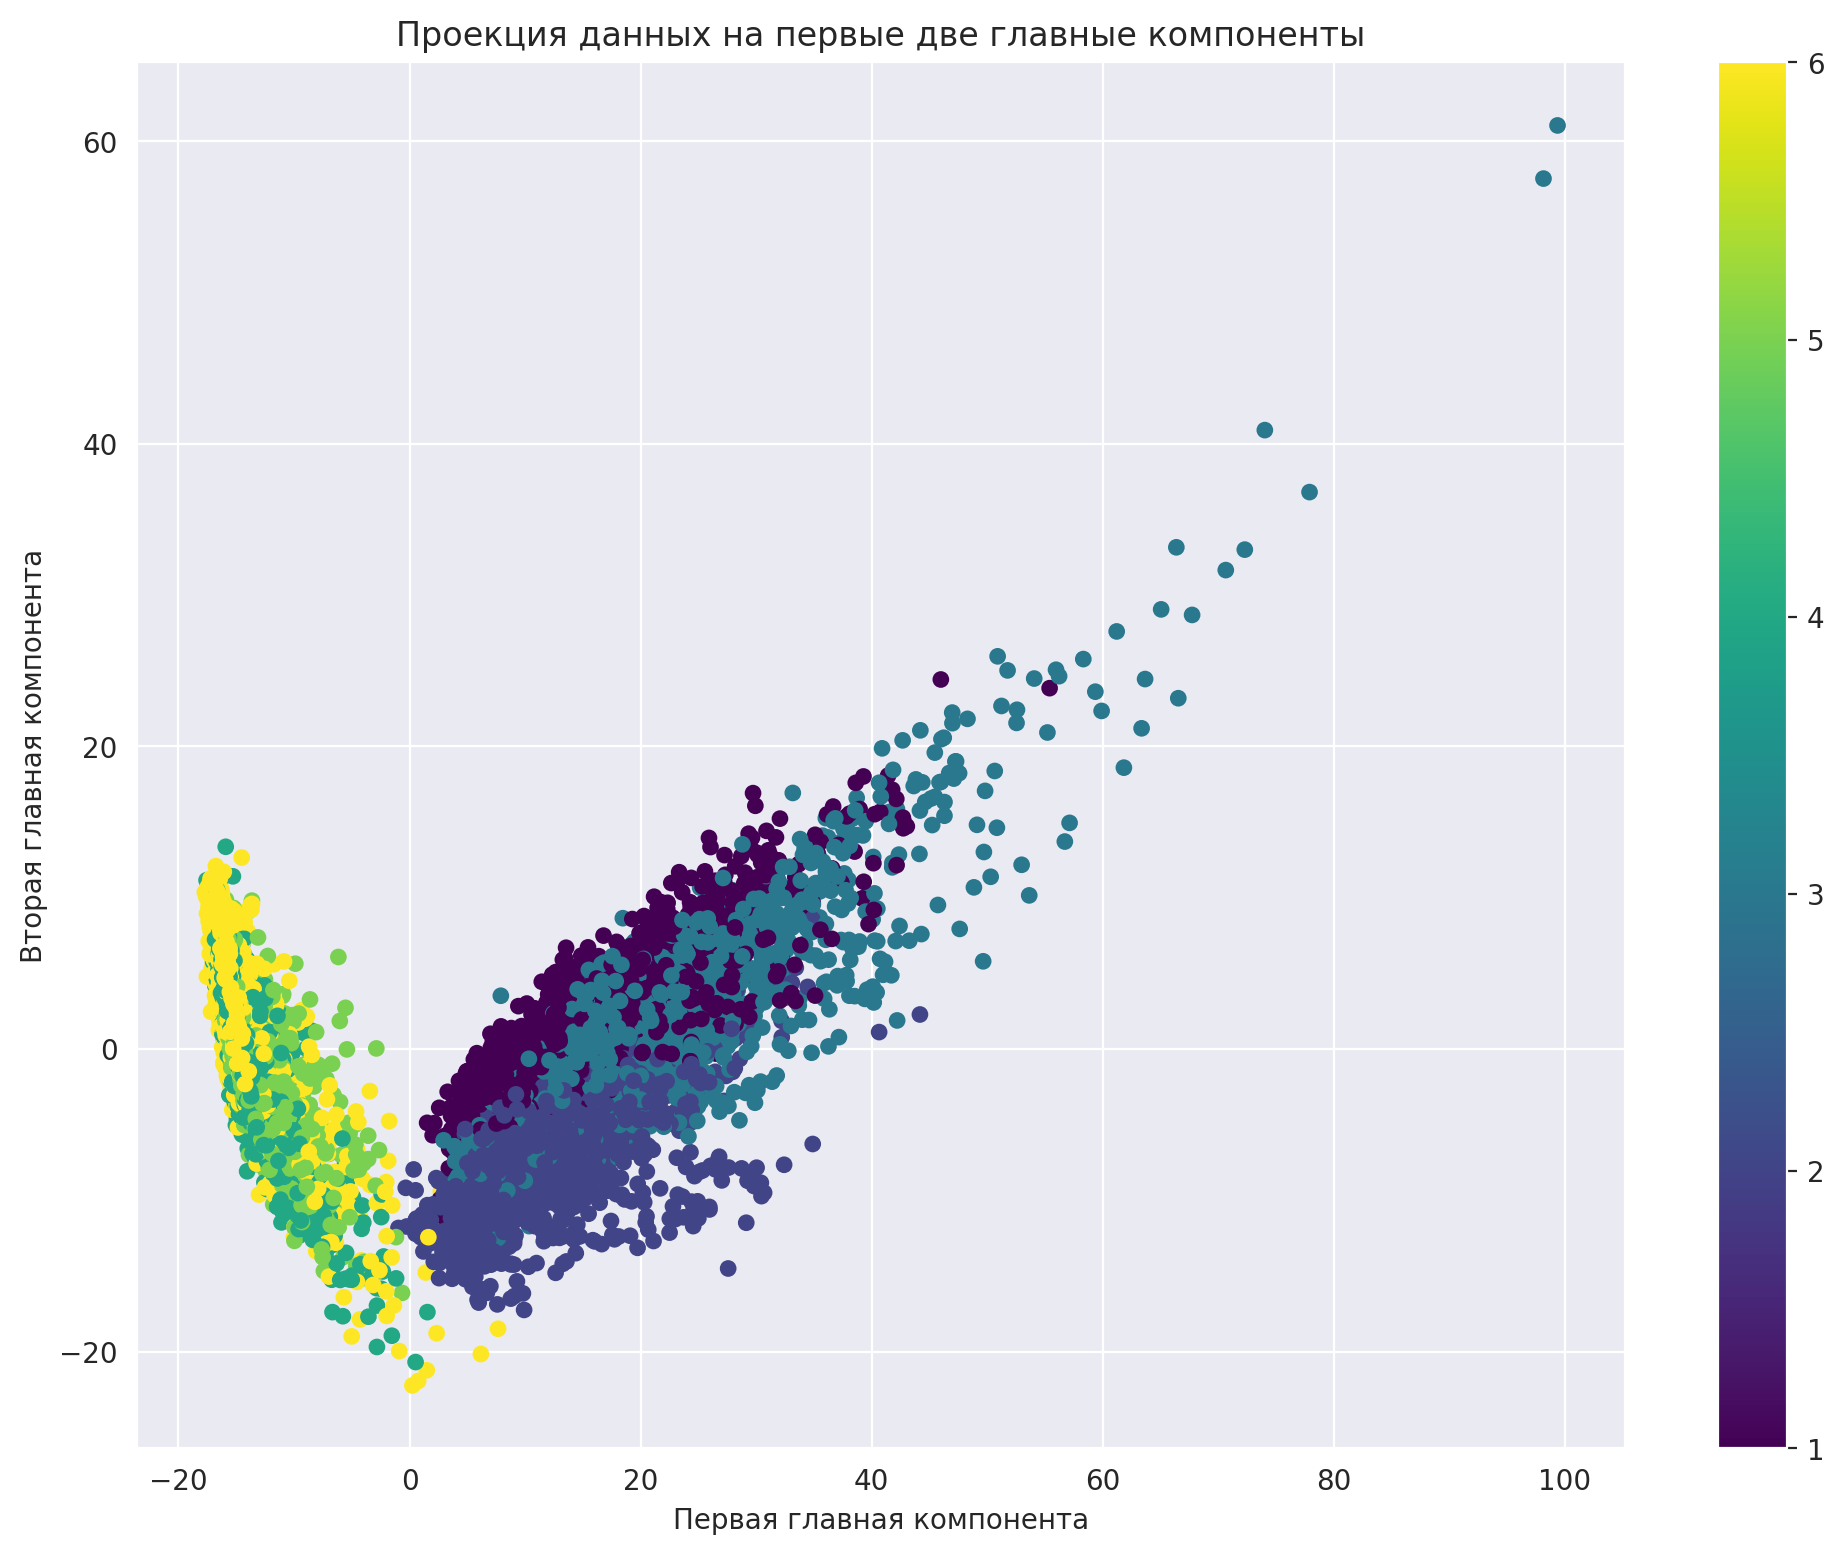

In [58]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=25)
plt.title("Проекция данных на первые две главные компоненты")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.colorbar()
plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [59]:
kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)

start_time = time()
kmeans.fit(X_pca)
end_time = time()

print(f"Время обучения: {end_time - start_time:.2f} секунд")

Время обучения: 10.91 секунд


In [60]:
start_infer_time = time()
clusters = kmeans.predict(X_pca)
end_infer_time = time()

print(f"Время инференса: {end_infer_time - start_infer_time:.4f} секунд")

Время инференса: 0.0032 секунд


### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

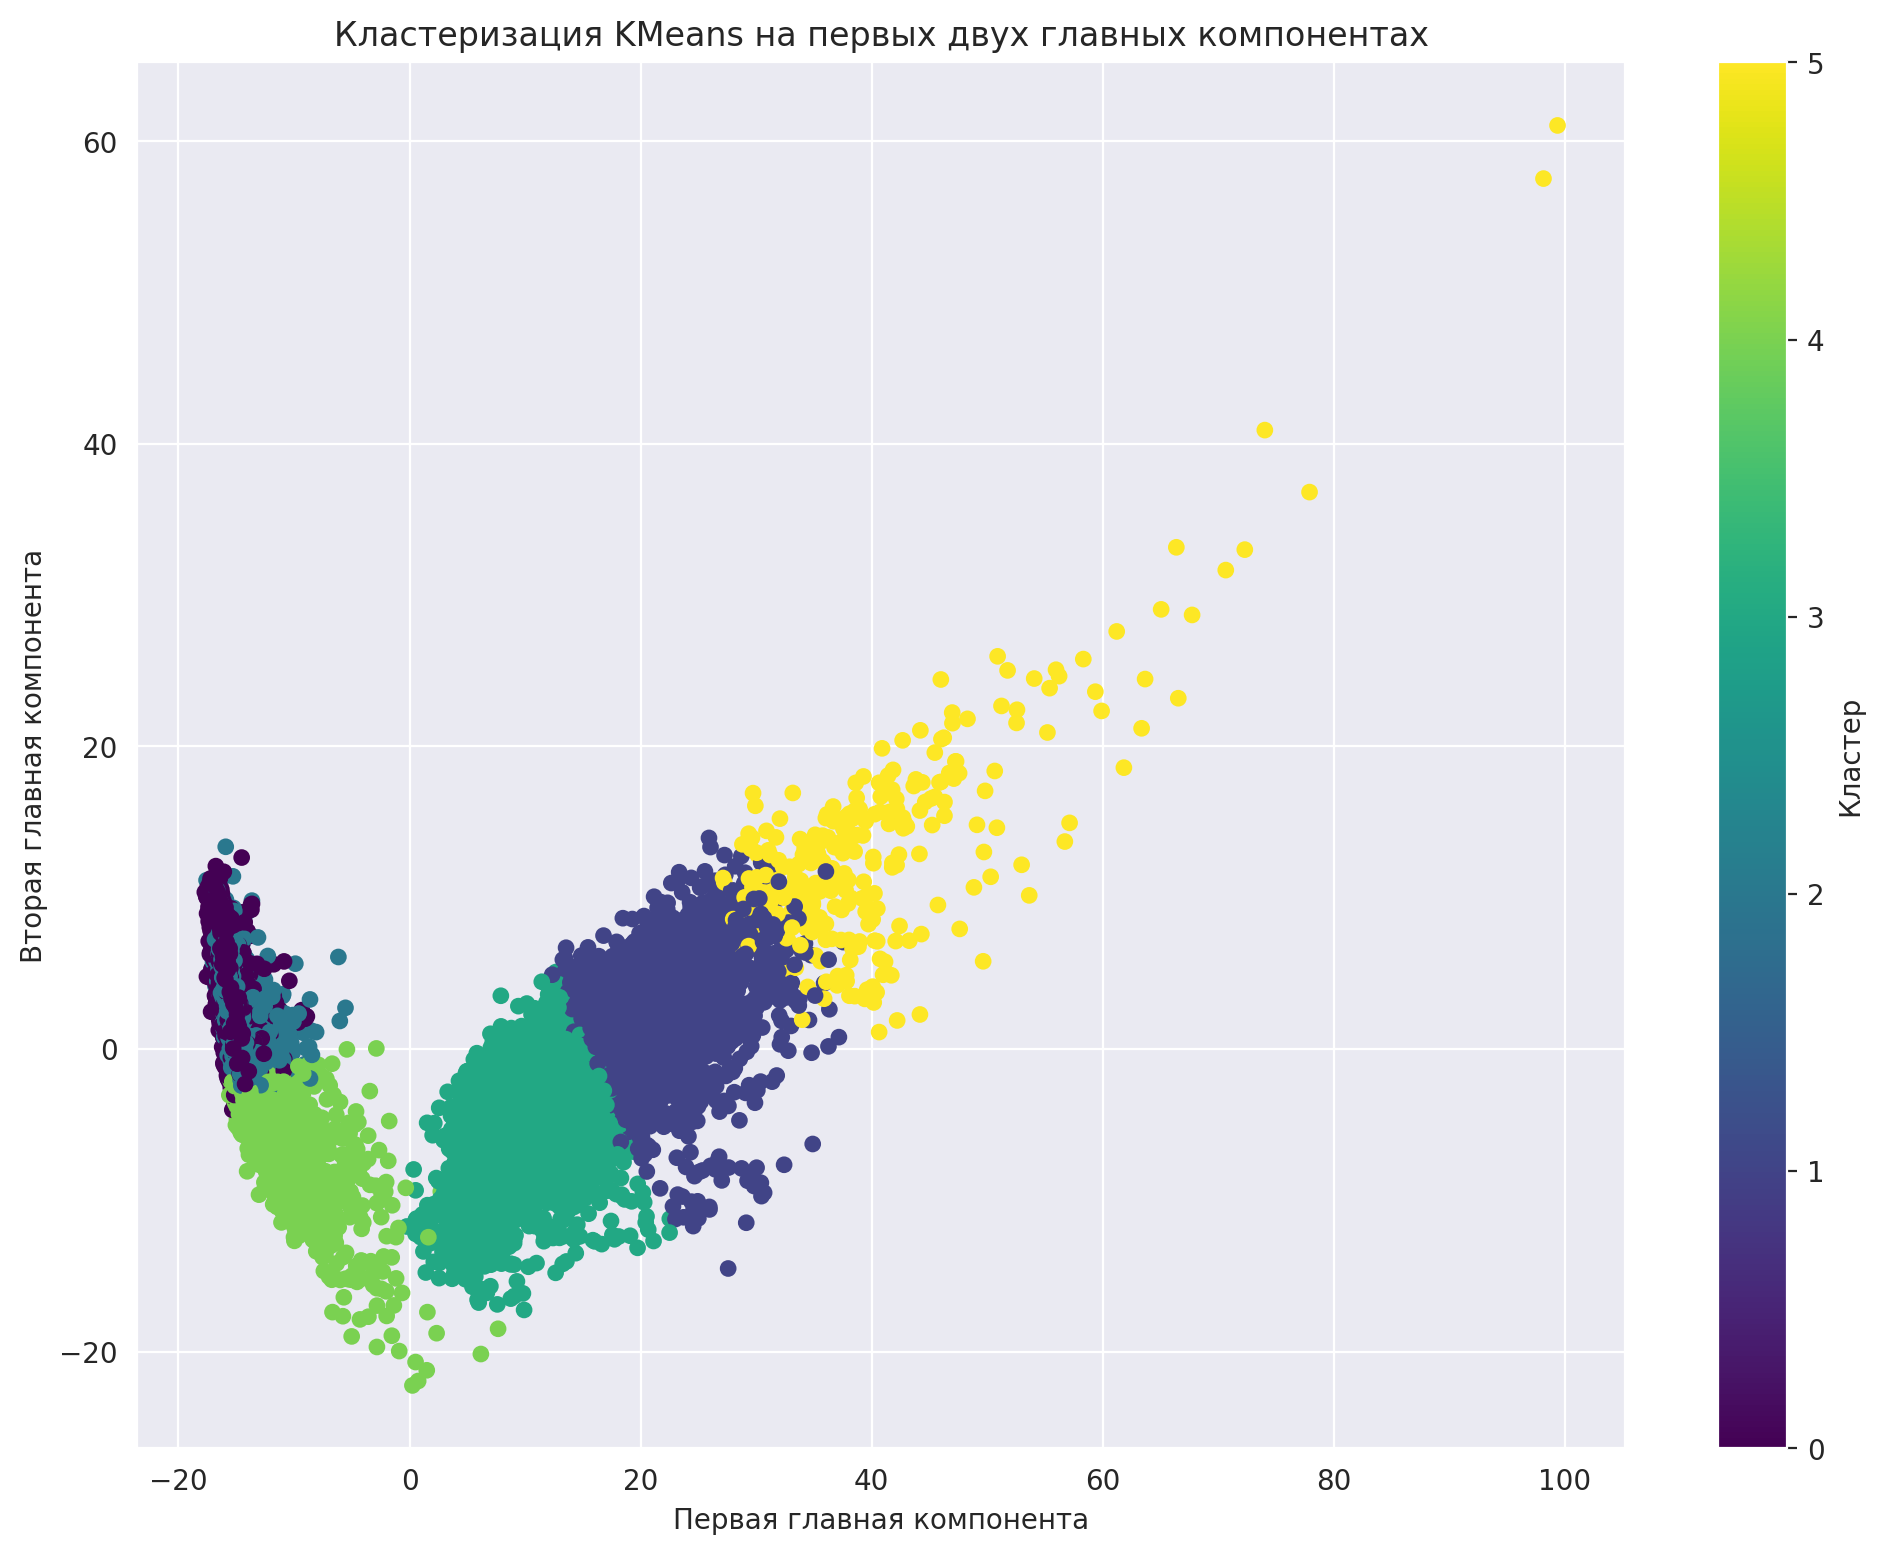

In [61]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=25)
plt.title("Кластеризация KMeans на первых двух главных компонентах")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.colorbar(label='Кластер')
plt.show()


### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [62]:
f"Средняя значение силуэта: {silhouette_score(X_pca, clusters):.2f}"

'Средняя значение силуэта: 0.14'

In [63]:
f"Чистота кластеров (ARI): {adjusted_rand_score(y, clusters):.2f}"


'Чистота кластеров (ARI): 0.42'

Силуэт (silhouette_score). Этот показатель говорит нам, насколько хорошо каждый объект вписывается в свой кластер по сравнению с другими. Значения диапазона от -1 до 1, где чем выше значение — тем лучше кластеризация получается;

Чистота кластеров (adjusted_rand_score). Эта метрика нужна для того, чтобы понять, насколько наши полученные кластеры соответствуют реальным точкам

**Ваш вывод здесь**

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [64]:
agg_clustering = AgglomerativeClustering(n_clusters=6)

start_agg_time = time()

agg_labels = agg_clustering.fit_predict(X_pca)

end_agg_time = time()

print(f"Время обучения AgglomerativeClustering: {end_agg_time - start_agg_time:.2f} секунд")

Время обучения AgglomerativeClustering: 8.46 секунд


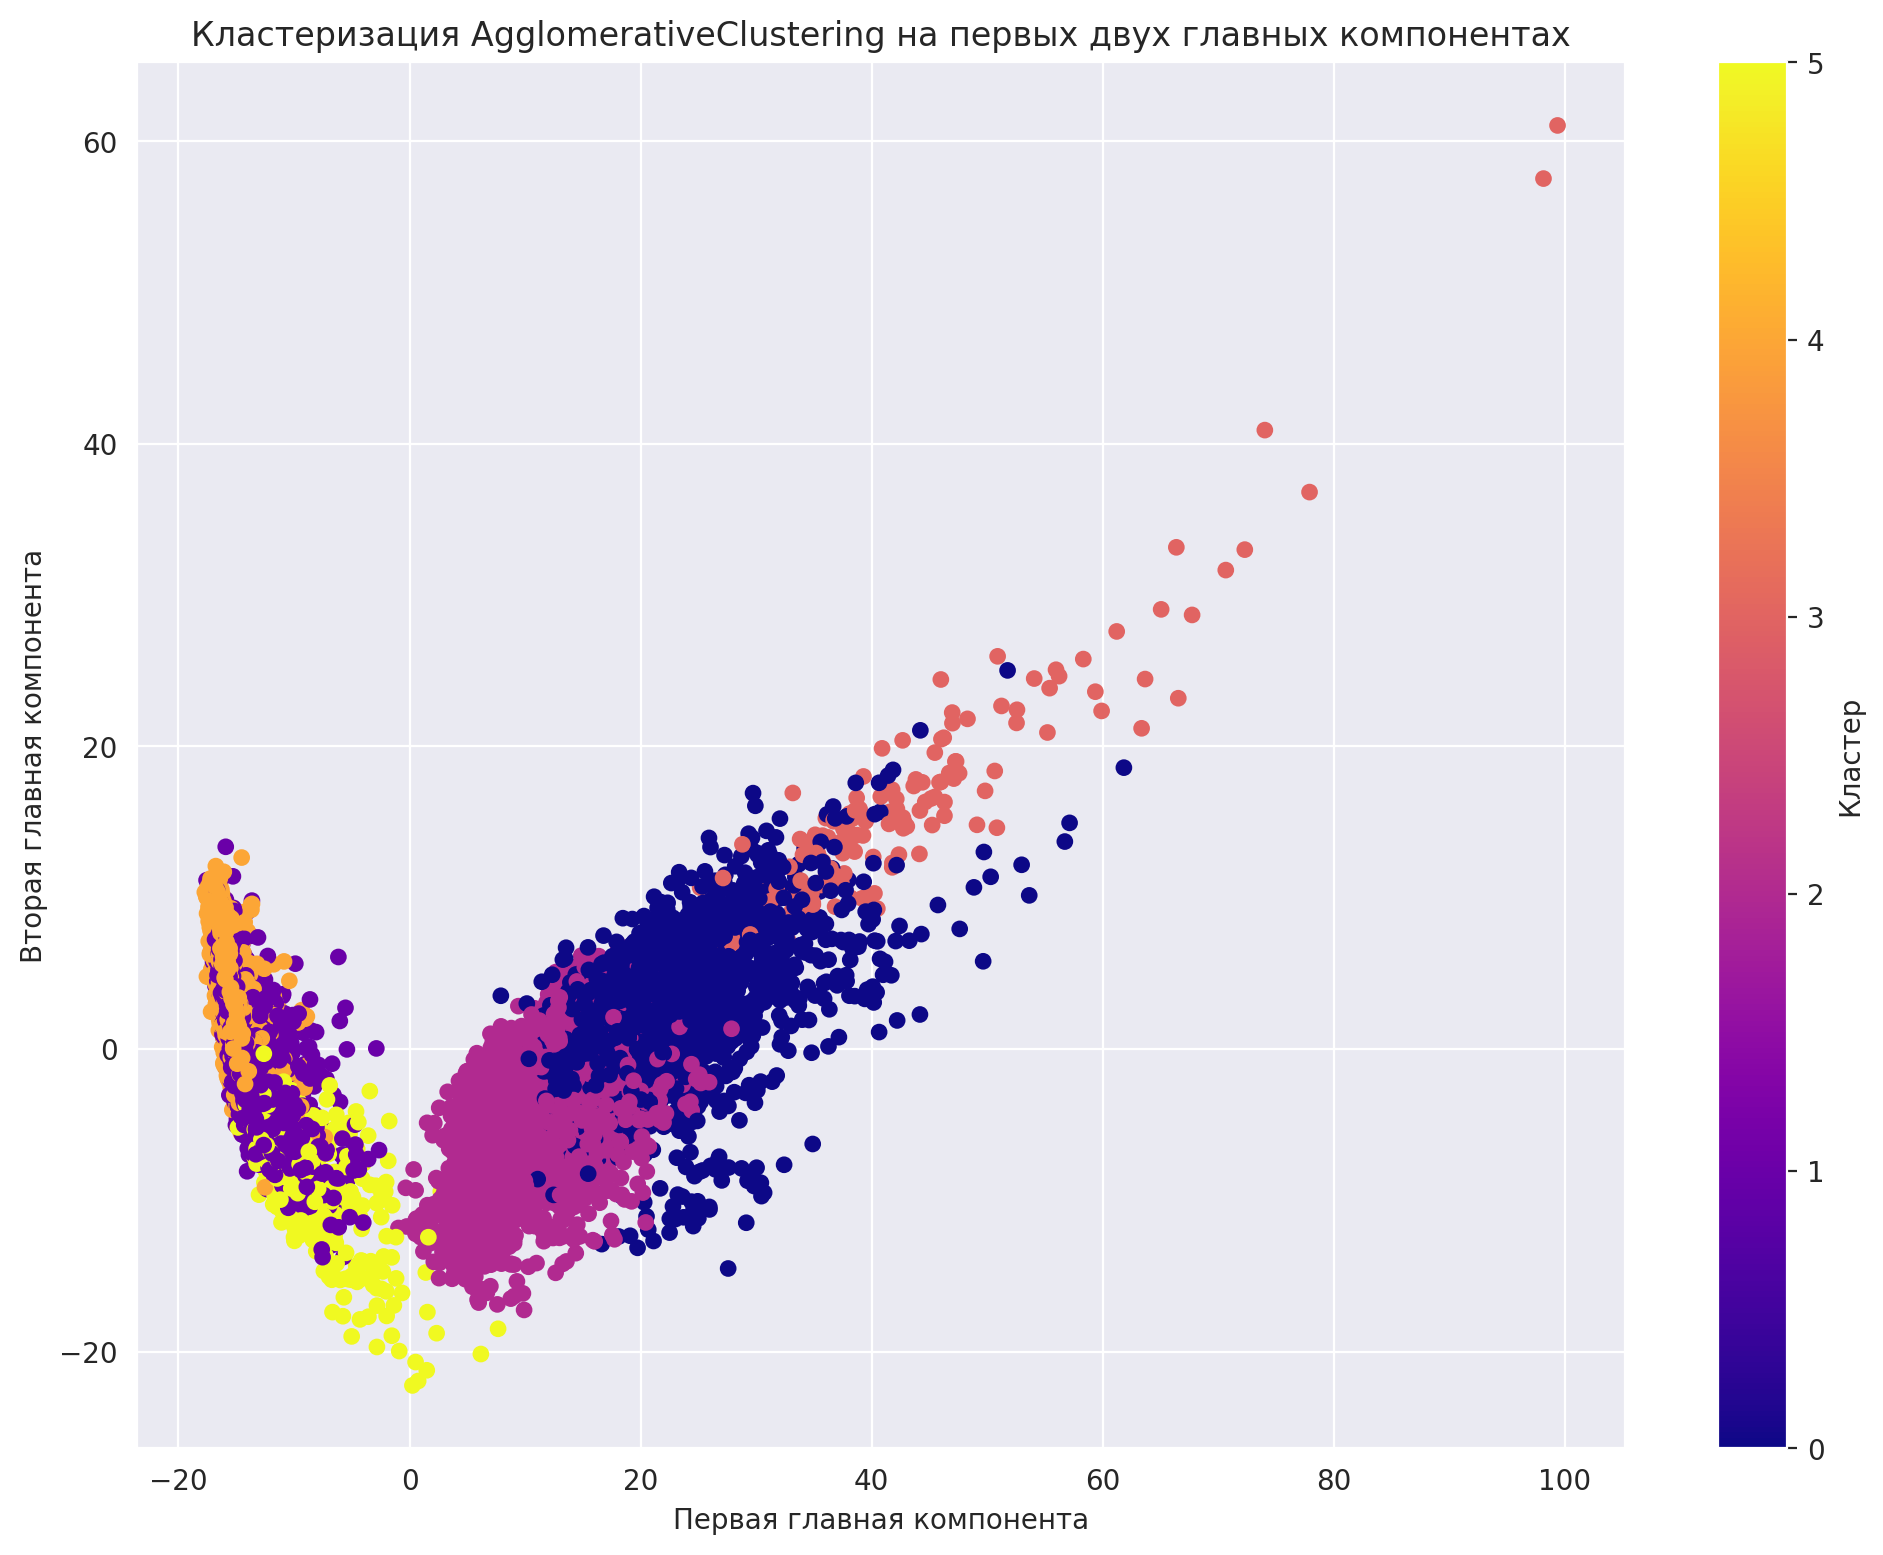

In [65]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='plasma', s=25)
plt.title("Кластеризация AgglomerativeClustering на первых двух главных компонентах")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.colorbar(label='Кластер')
plt.show()

In [66]:
silhouette_avg_agg = silhouette_score(X_pca, agg_labels)
ari_score_agg = adjusted_rand_score(y, agg_labels)

In [67]:
print(f"Средняя значение силуэта для AgglomerativeClustering: {silhouette_avg_agg:.2f}")
print(f"Чистота кластеров (ARI) для AgglomerativeClustering: {ari_score_agg:.2f}")

Средняя значение силуэта для AgglomerativeClustering: 0.14
Чистота кластеров (ARI) для AgglomerativeClustering: 0.49


In [68]:
print(f"Сравнение времени обучения: KMeans {end_time - start_time:.2f} секунд, Agglomerative {end_agg_time - start_agg_time:.2f} секунд")

Сравнение времени обучения: KMeans 10.91 секунд, Agglomerative 8.46 секунд


Агломеративная работает побыстрее, однако точность модели упала!

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

Возможно несколько видов активности могут быть смешены, в виду их близости в реальной жизни. К примеру, Бег и ходьба будут далеки от плаванья, но близки между собой и т.д. Кластеризация получилась качественной, судя по метрикам и визуалу!

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here
    pass

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

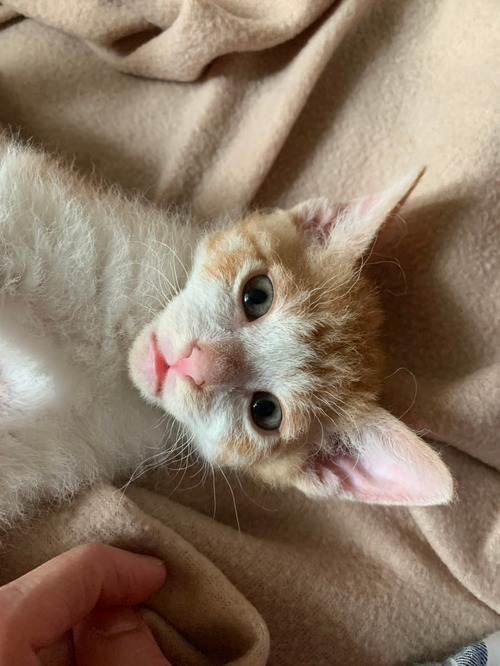